In [16]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [17]:
#回归问题评价指标
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
#分类问题评价指标
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss#对数损失（交叉熵损失）

In [18]:
#定义函数计算评价指标
def calculate_metrics_two(y_true,y_pred):#二分类
    accuracy=accuracy_score(y_true,y_pred)
    sensitivity=recall_score(y_true,y_pred)#敏感性（召回率）
    specificity=confusion_matrix(y_true,y_pred)[0,0]/(confusion_matrix(y_true,y_pred)[0,0]+confusion_matrix(y_true,y_pred)[0,1])
    positive_predictive_values=precision_score(y_true,y_pred)
    negative_predictive_value=confusion_matrix(y_true,y_pred)[1,1]/(confusion_matrix(y_true,y_pred)[1,1]+confusion_matrix(y_true,y_pred)[1,0])
    f1=f1_score(y_true,y_pred)
    kappa=cohen_kappa_score(y_true,y_pred)
    return [accuracy,sensitivity,specificity,positive_predictive_values,negative_predictive_value,f1,kappa]

def calculate_metrics_multi(y_true,y_pred):#多分类
    accuracy=accuracy_score(y_true,y_pred)
    precision=precision_score(y_true,y_pred,average='macro')
    recall=recall_score(y_true,y_pred,average='macro')
    f1=f1_score(y_true,y_pred,average='macro')
    kappa=cohen_kappa_score(y_true,y_pred)
    return [accuracy,precision,recall,f1,kappa]

In [19]:
data=pd.read_excel('FTIR.xlsx',index_col=0)
X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values
columns=data.iloc[:,:-1].columns.values


In [20]:
# 将数据分为训练集、验证集和测试集
from sklearn.model_selection import train_test_split

# 第一次划分：70%训练集，30%为临时集（包含验证集和测试集）
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)

# 第二次划分：从临时集中划分出验证集和测试集（1:2的比例）
# 30% * (1/3) = 10% 验证集
# 30% * (2/3) = 20% 测试集
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=123)

# 打印各个数据集的形状
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_val.shape:', X_val.shape)
print('y_val.shape:', y_val.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (126, 3351)
y_train.shape: (126,)
X_val.shape: (18, 3351)
y_val.shape: (18,)
X_test.shape: (36, 3351)
y_test.shape: (36,)


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import  pandas as pd
from sklearn.cross_decomposition import PLSRegression
from matplotlib import pyplot as plt

def accuracy_component(xc, xv, yc, yv, component=8, n_fold=5):
    # xc表示训练集,xv表示测试集,yc表示训练标签,yv表示测试标签,component表示最多个数,n_fold表示分为几组样本(每次一组作为测试集,交叉验证)
    k_range = np.linspace(start=1, stop=component, num=component)

    kf = KFold(n_splits=n_fold, random_state=None, shuffle=True)  # n_splits表示要分割为多少个K子集,交叉验证需要

    accuracy_validation = np.zeros((1, component))  # 用于存储各个成分数的测试平均精准度accuracy
    accuracy_train = np.zeros((1, component))  # 用于存储各个成分数的训练平均精准度accuracy
    for j in range(component):  # j∈[0,component-1],j+1∈[1,component]
        p = 0
        acc = 0  # acc表示总的精准度,p表示个数,acc/p平均精确度
        # 下面是普通训练
        model_pls = PLSRegression(n_components=j + 1)  # 此时选择component个成分
        yc_labels = pd.get_dummies(yc)
        model_pls.fit(xc, yc_labels)
        y_pred = model_pls.predict(xv)
        y_pred = np.array([np.argmax(i) for i in y_pred])
        accuracy_train[:, j] = accuracy_score(yv, y_pred)  # 这是直接训练的
        # 下面是交叉验证
        for train_index, test_index in kf.split(xc):  # 进行n_fold轮交叉验证
            # 划分数据集
            X_train, X_test = xc[train_index], xc[test_index]
            y_train, y_test = yc[train_index], yc[test_index]
            YC_labels = pd.get_dummies(y_train)  # 训练数据结果独热编码
            model_1 = PLSRegression(n_components=j + 1)
            model_1.fit(X_train, YC_labels)
            Y_pred = model_1.predict(X_test)
            Y_pred = np.array([np.argmax(i1) for i1 in Y_pred])  # 独热编码转化成类别变量
            acc = accuracy_score(y_test, Y_pred) + acc
            p = p + 1
        accuracy_validation[:, j] = acc / p  # 计算j+1个成分的平均精准度
    # 首先对于每个component数训练一个模型,然后利用测试集得出准确率
    print('模型训练的准确率')
    print(accuracy_train)
    # 然后对样本的训练集进行交叉验证
    print('交叉验证的平均准确率')
    print(accuracy_validation)
    plt.plot(k_range, accuracy_train.T, 'o-', label="Training", color="r")
    plt.plot(k_range, accuracy_validation.T, 'o-', label="Cross-validation", color="b")
    plt.xlabel("N components")
    plt.ylabel("Score")
    plt.legend(loc="best")  # 选取最佳位置标注图注
    plt.rc('font', family='Times New Roman')
    plt.rcParams['font.size'] = 10
    plt.show()
    return accuracy_validation, accuracy_train

In [22]:
def PLS_DA(train_X, val_X, test_X, train_y,val_y, test_y,n_components):
    # 建模
    model = PLSRegression(n_components=n_components)
    train_y = pd.get_dummies(train_y)
    model.fit(train_X, train_y)
    # 预测
    y_pred_test = model.predict(test_X)
    y_pred_val = model.predict(val_X)
    y_pred_train = model.predict(train_X)
    # 将预测结果（类别矩阵）转换为数值标签
    y_pred_test = np.array([np.argmax(i) for i in y_pred_test])
    y_pred_val = np.array([np.argmax(i) for i in y_pred_val])
    y_pred_train = np.array([np.argmax(i) for i in y_pred_train])
    # 模型评价---混淆矩阵和精度
    print('测试集混淆矩阵为：\n', confusion_matrix(test_y, y_pred_test))
    print('平均分类准确率为：\n', accuracy_score(test_y, y_pred_test))
    return y_pred_train,y_pred_val,y_pred_test


模型训练的准确率
[[0.52777778 0.58333333 0.80555556 0.83333333 0.83333333 0.86111111
  0.86111111 0.91666667 0.97222222 1.         1.         0.97222222
  0.97222222 1.         1.         0.97222222 1.         0.97222222
  0.97222222 0.97222222]]
交叉验证的平均准确率
[[0.58141026 0.64230769 0.75512821 0.78333333 0.84038462 0.89551282
  0.88076923 0.92820513 0.94423077 0.94487179 0.96025641 0.93012821
  0.94294872 0.95192308 0.9525641  0.95192308 0.96025641 0.96025641
  0.92564103 0.95897436]]


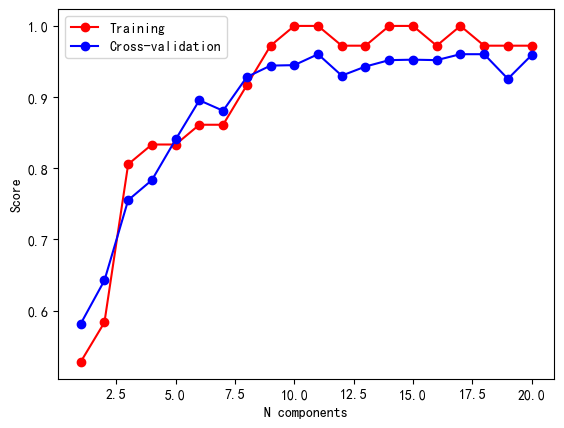

In [23]:
accuracy_validations, accuracy_trains=accuracy_component(X_train, X_test, y_train, y_test, component=20, n_fold=10)
plt.rcParams["font.family"] = "Times New Roman"

In [24]:
y_pred_train,y_pred_val,y_pred_test=PLS_DA(X_train,X_val, X_test, y_train,y_val, y_test,n_components=7)

测试集混淆矩阵为：
 [[ 7  0  0]
 [ 2 10  1]
 [ 1  1 14]]
平均分类准确率为：
 0.8611111111111112


In [25]:
[accuracy_train,precision_train,recall_train,f1_train,kappa_train]=calculate_metrics_multi(y_pred_train,y_train) 
[accuracy_val,precision_val,recall_val,f1_val,kappa_val]=calculate_metrics_multi(y_pred_val,y_val)
[accuracy_test,precision_test,recall_test,f1_test,kappa_test]=calculate_metrics_multi(y_pred_test,y_test) 
print("训练集准确率",accuracy_train) 
print("训练集精确率",precision_train) 
print("训练集召回率：",recall_train) 
print("训练集F1分数：",f1_train) 
print("训练集Kappa系数：",kappa_train) 

print("验证集准确率：",accuracy_val)
print("验证集精确率",precision_val)
print("验证集召回率",recall_val)
print("验证集F1分数：",f1_val)
print("验证集Kappa系数：",kappa_val)

print("测试集准确率：",accuracy_test) 
print("测试集精确率",precision_test) 
print("测试集召回率",recall_test) 
print("测试集F1分数：",f1_test) 
print("测试集Kappa系数：",kappa_test)

训练集准确率 0.9206349206349206
训练集精确率 0.9212121212121213
训练集召回率： 0.9226049035406367
训练集F1分数： 0.920338264951616
训练集Kappa系数： 0.8808848553601815
验证集准确率： 0.8333333333333334
验证集精确率 0.736111111111111
验证集召回率 0.7592592592592592
验证集F1分数： 0.7361111111111112
验证集Kappa系数： 0.728643216080402
测试集准确率： 0.8611111111111112
测试集精确率 0.8814102564102564
测试集召回率 0.8474747474747474
测试集F1分数： 0.8533628505165507
测试集Kappa系数： 0.7864768683274022


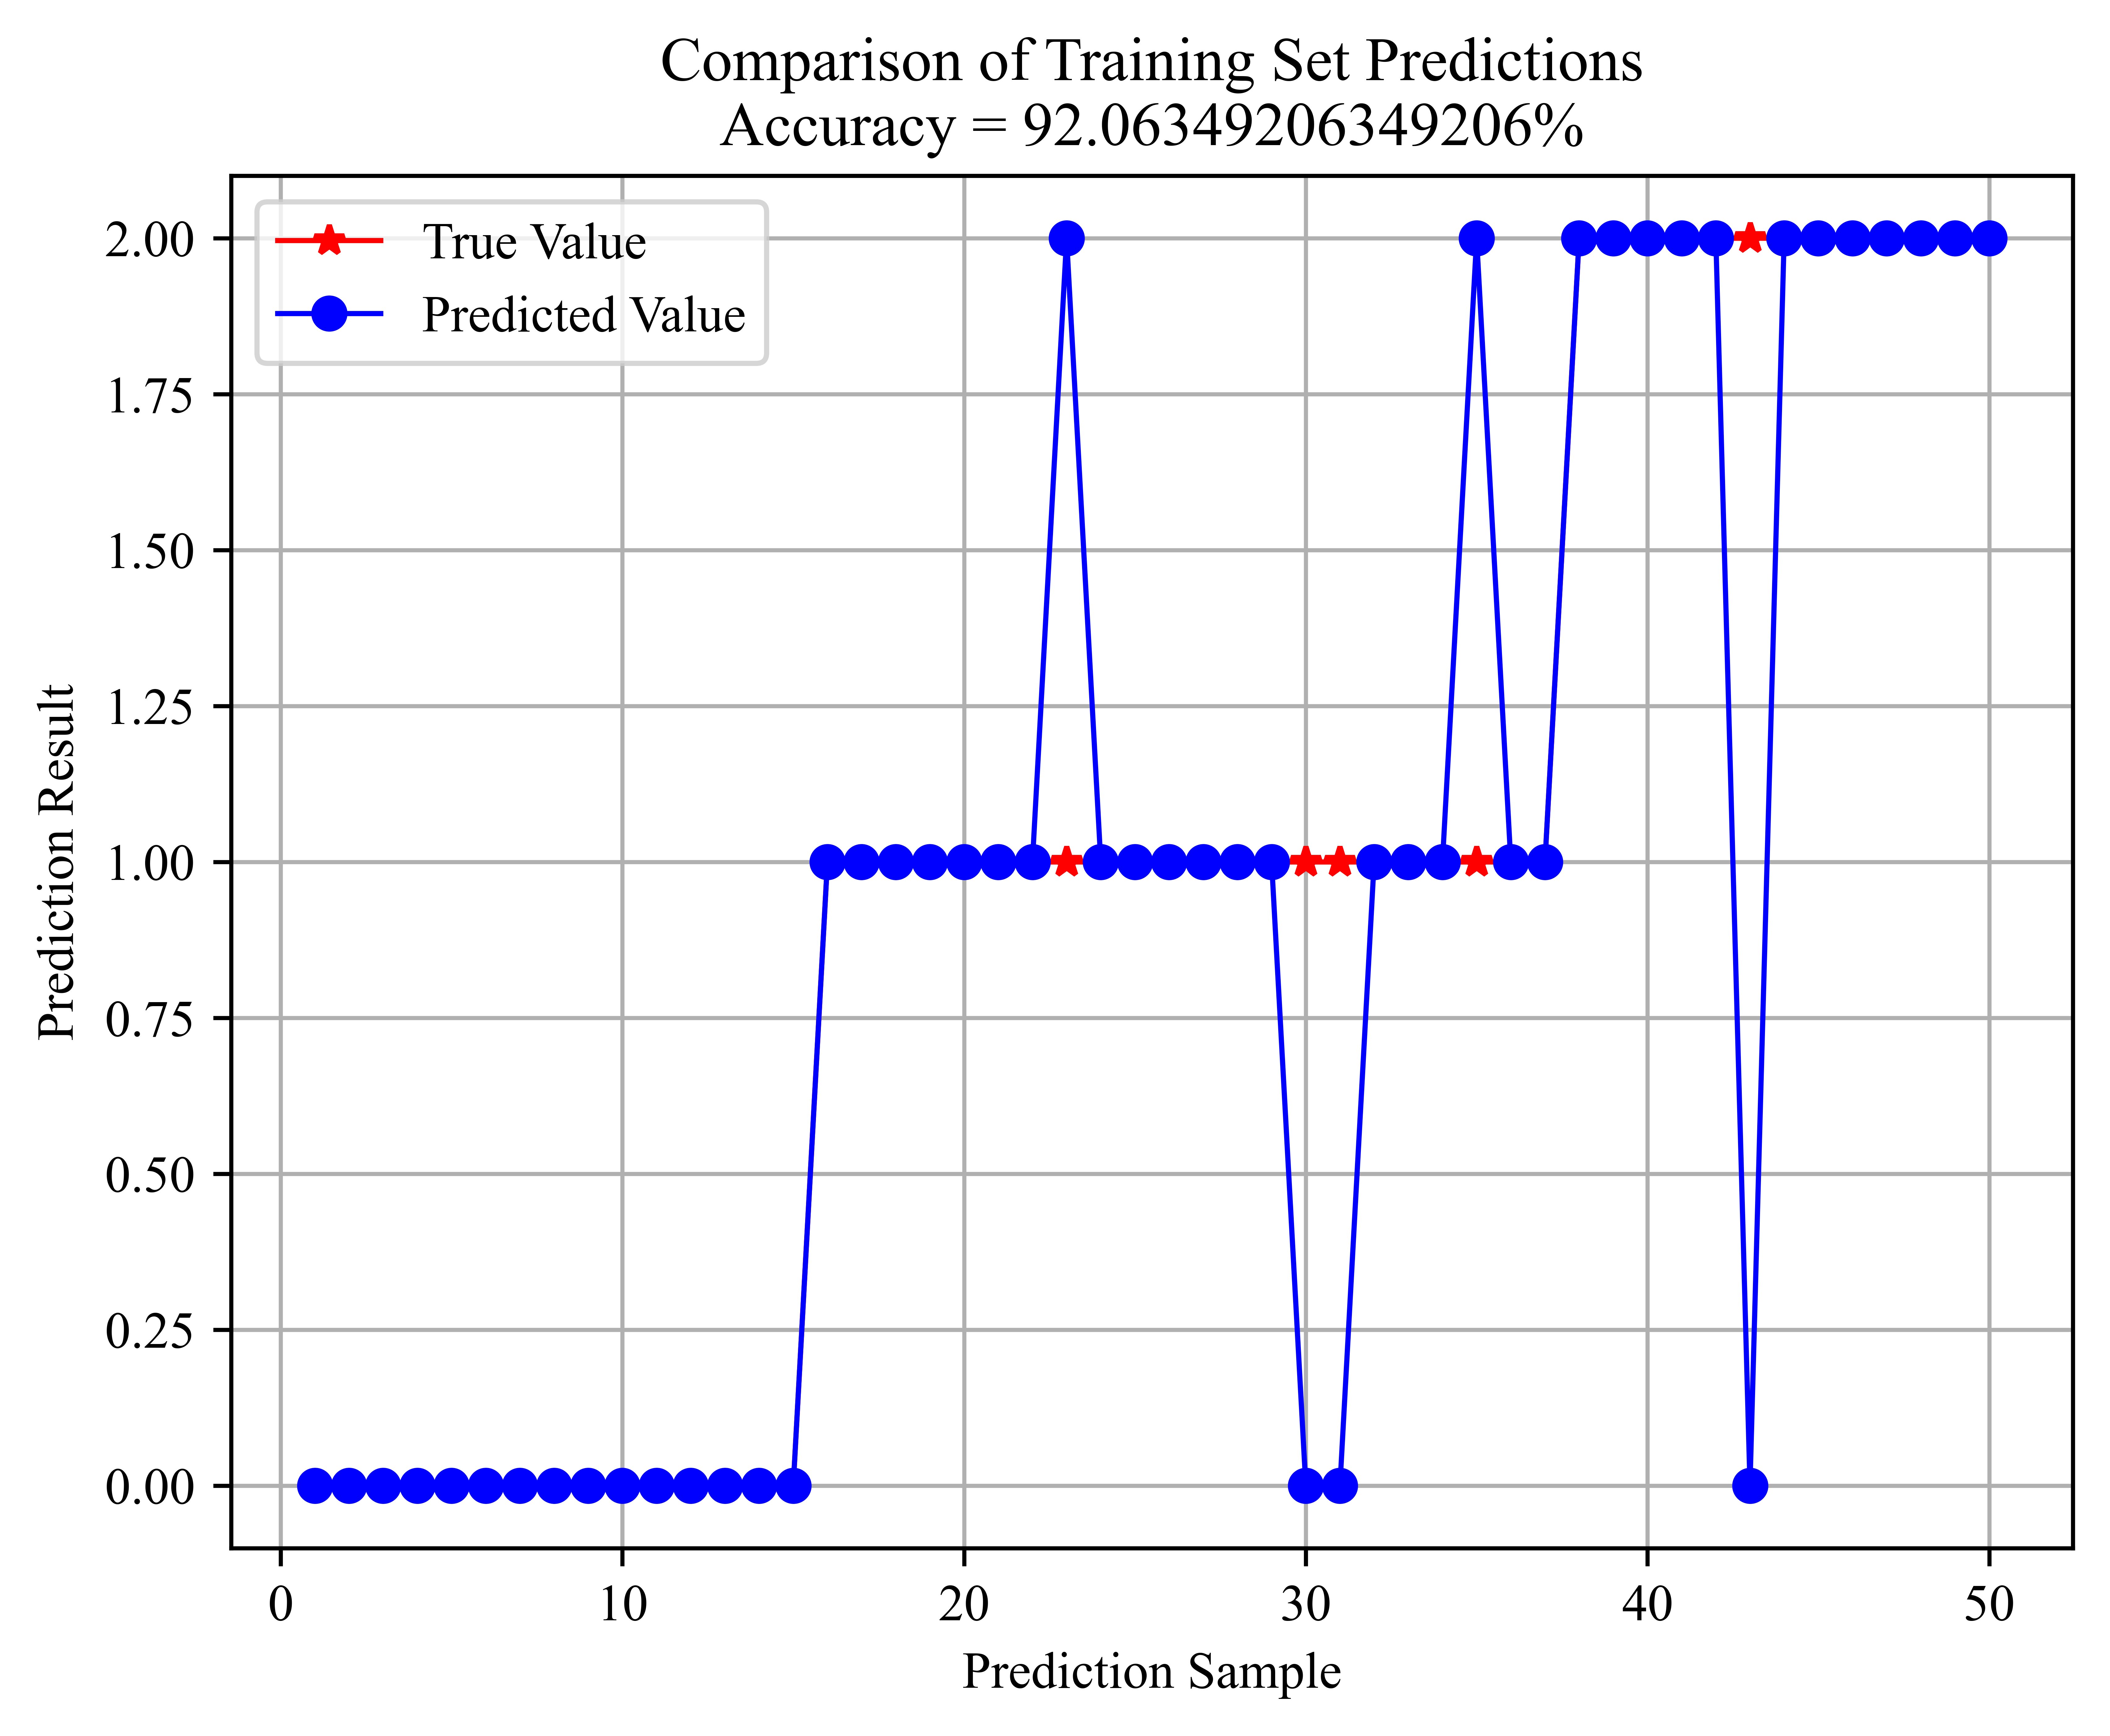

In [26]:
N = len(y_train)
index_50_train=np.random.choice(range(0, N), 50, replace=True)#随机挑选50个样本出来，样本太多不好显示
y_train_=y_train[index_50_train]
y_train_pred_=y_pred_train[index_50_train]

index_train = np.argsort(y_train_)
y_train_sort = np.sort(y_train_)

y_pred_train_sort = np.array(y_train_pred_)[index_train]

plt.figure( dpi=1200)

plt.rcParams["font.family"] = "Times New Roman"

# 绘制真实值曲线
plt.plot(np.arange(1, 50+1), y_train_sort, 'r-*', label='True Value', linewidth=1)

# 绘制预测值曲线
plt.plot(np.arange(1, 50+1), y_pred_train_sort, 'b-o', label='Predicted Value', linewidth=1)

# 添加图例
plt.legend()

# 设置x轴标签
plt.xlabel('Prediction Sample')

# 设置y轴标签
plt.ylabel('Prediction Result')

# 设置标题，将准确率信息添加到标题中
string = f"Comparison of Training Set Predictions\nAccuracy = {accuracy_train*100}%"
plt.title(string)

# 添加网格
plt.grid()

# 显示图形
plt.show()

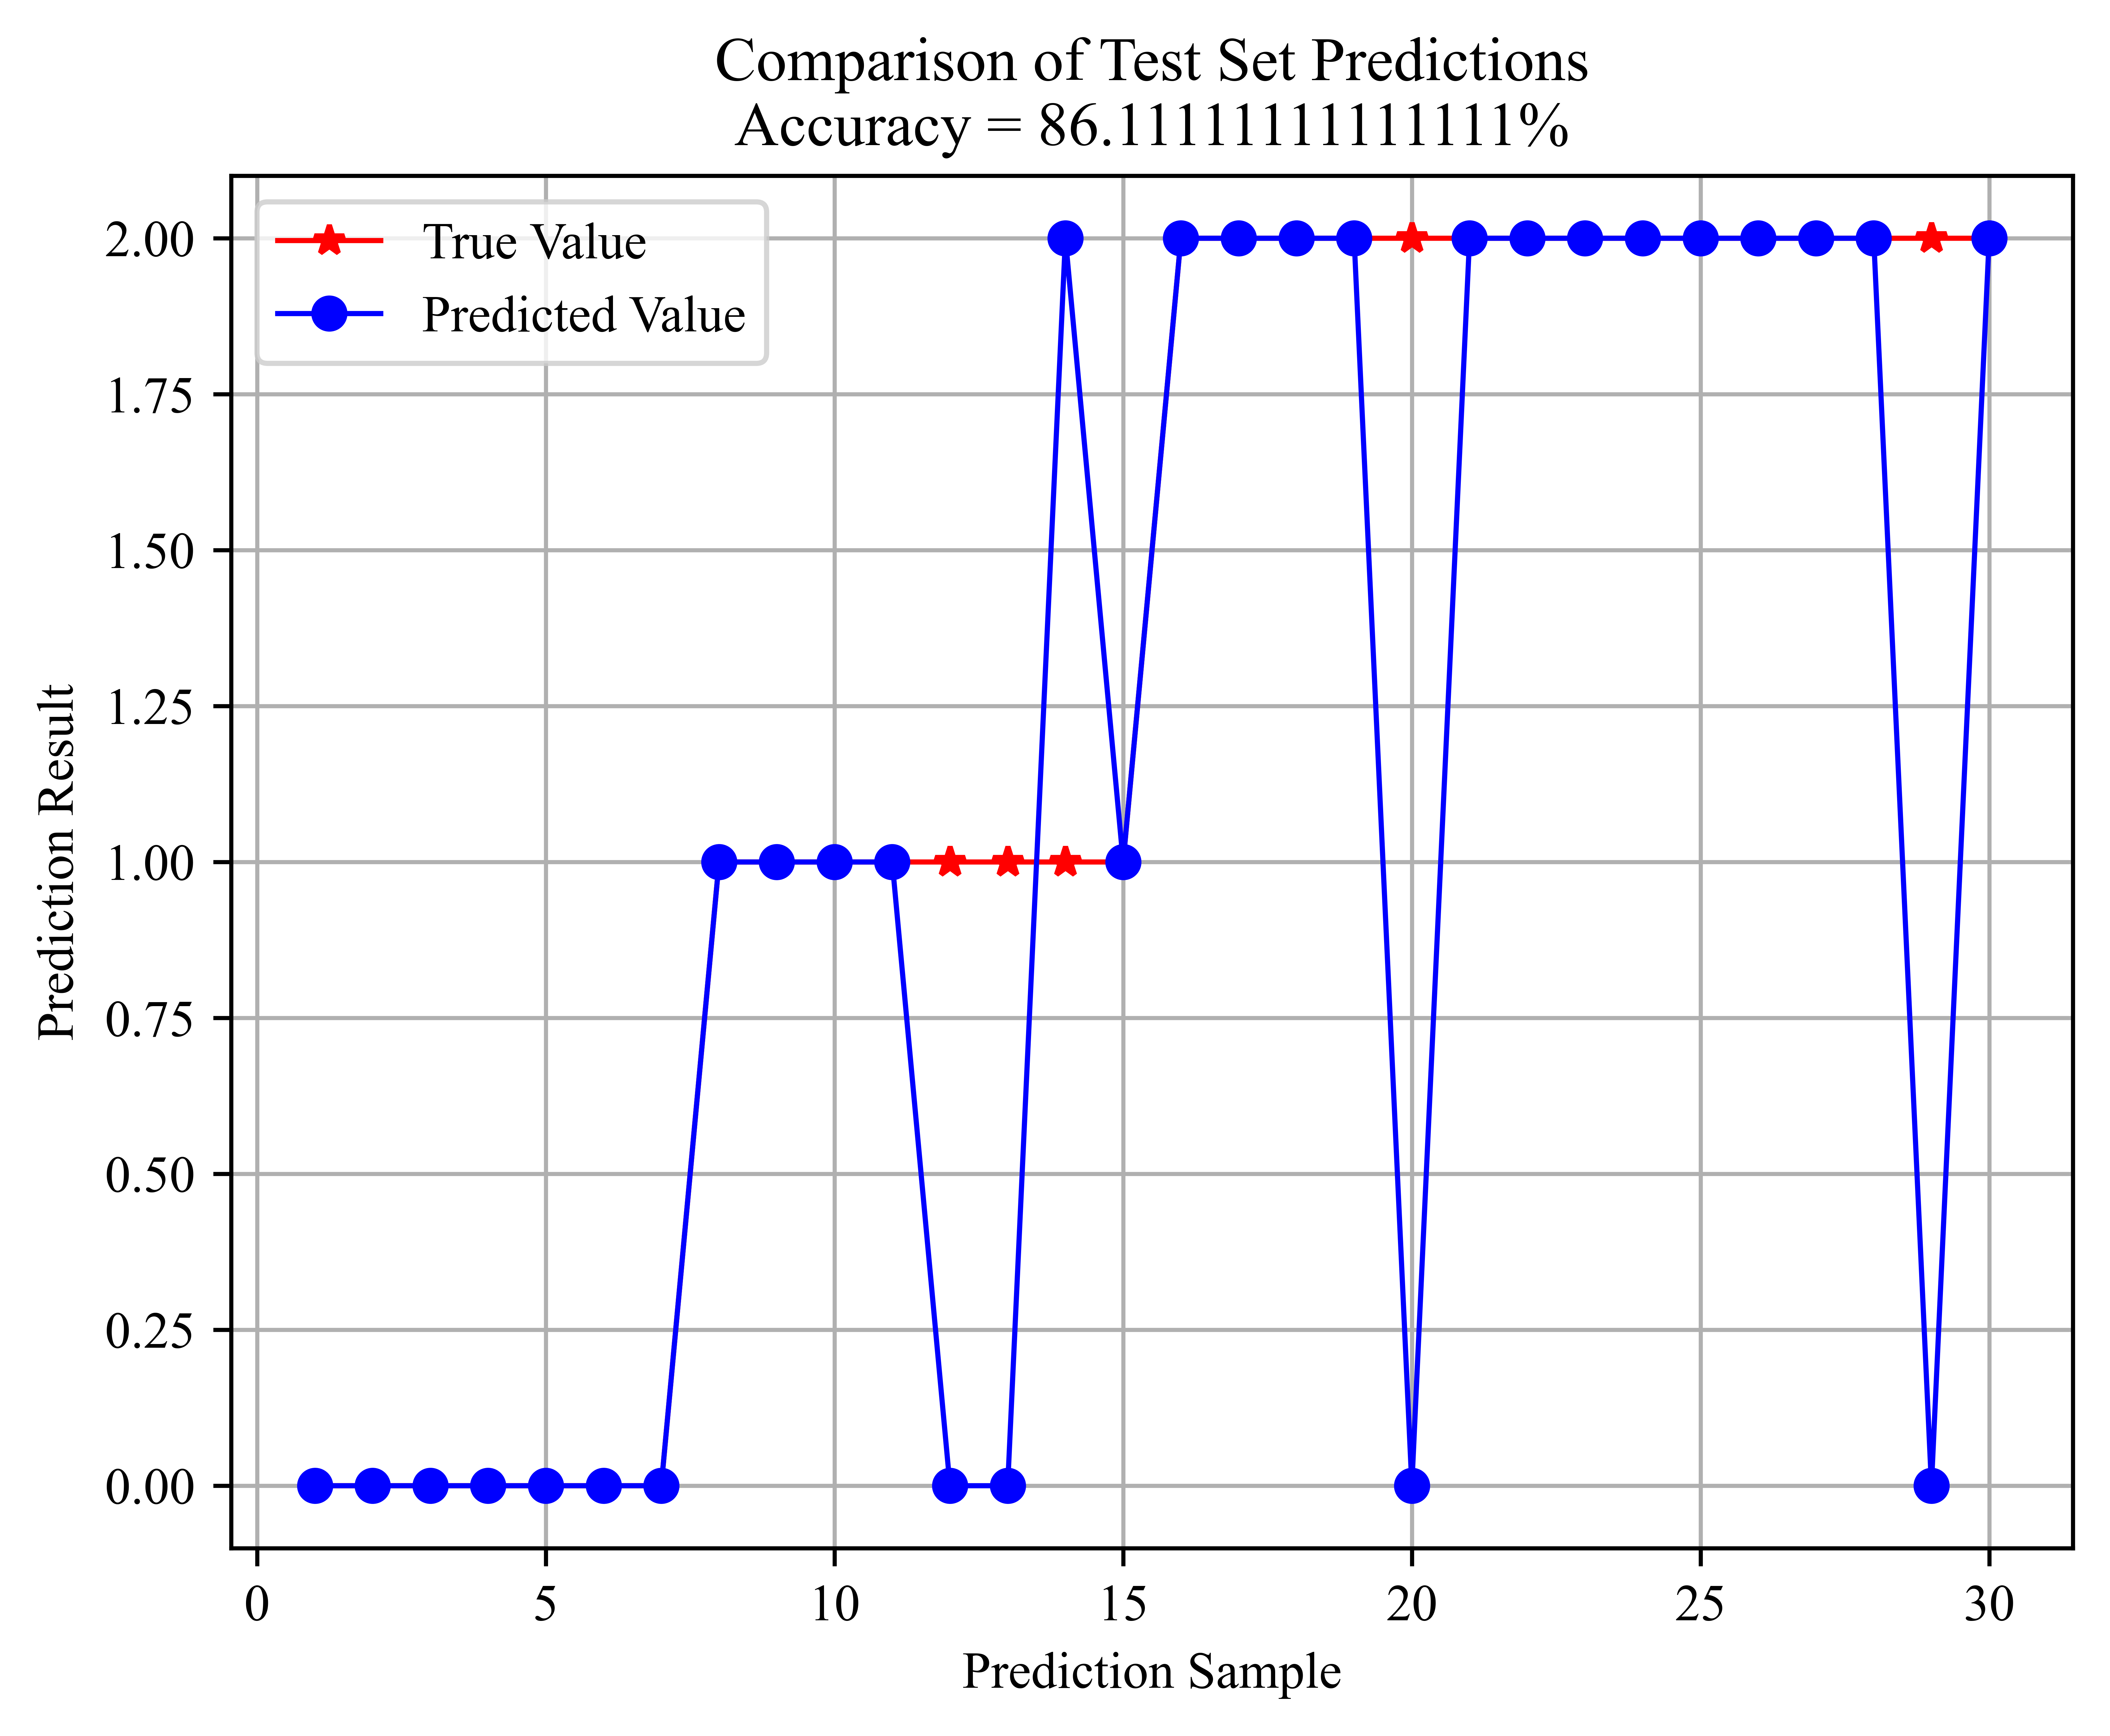

In [27]:
N = len(y_test)
index_30_test=np.random.choice(range(0, N), 30, replace=True)#随机挑选20个样本出来，样本太多不好显示
y_test_=y_test[index_30_test]
y_test_pred_=y_pred_test[index_30_test]

index_test= np.argsort(y_test_)
y_test_sort = np.sort(y_test_)

y_pred_test_sort = np.array(y_test_pred_)[index_test]

plt.figure( dpi=1200)

plt.rcParams["font.family"] = "Times New Roman"

# 绘制真实值曲线
plt.plot(np.arange(1, 30 + 1), y_test_sort, 'r-*', label='True Value', linewidth=1)

# 绘制预测值曲线
plt.plot(np.arange(1, 30 + 1), y_pred_test_sort, 'b-o', label='Predicted Value', linewidth=1)

# 添加图例
plt.legend()

# 设置x轴标签
plt.xlabel('Prediction Sample')

# 设置y轴标签
plt.ylabel('Prediction Result')

# 设置标题，将准确率信息添加到标题中
string = f"Comparison of Test Set Predictions\nAccuracy = {accuracy_test*100}%"
plt.title(string)

# 添加网格
plt.grid()

# 显示图形
plt.show()

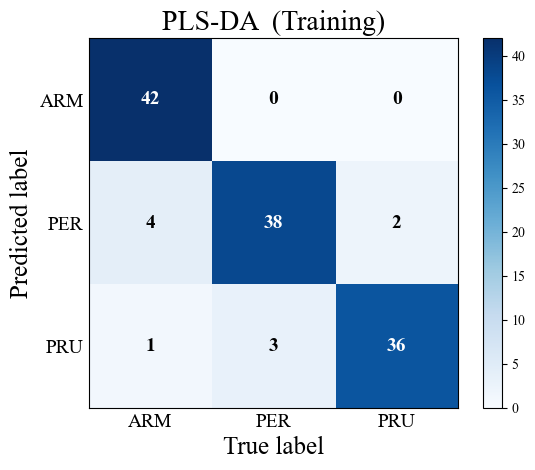

In [28]:
import scikitplot as skplt
mapping = { 0: 'ARM',   1: 'PER',2: 'PRU'} 

y_train_map= [mapping[i] if i in mapping else i for i in y_train] 
y_pred_train_map = [mapping[i] if i in mapping else i for i in np.array(y_pred_train)] 
plot = skplt.metrics.plot_confusion_matrix(y_train_map, y_pred_train_map)

plt.tick_params(axis='both', which='both', length=0)  
plt.title('PLS-DA  (Training)', fontsize=20)
# 设置标题和轴标签，并修改字体大小
plt.xlabel("True label", fontsize=18)  # X轴标签字体大小
plt.ylabel("Predicted label", fontsize=18)  # Y轴标签字体大小
# 调整刻度标签的字体大小
plt.xticks(fontsize=14)  # X轴刻度标签字体大小
plt.yticks(fontsize=14)  # Y轴刻度标签字体大小
# 调整单元格内数字的字体大小
for text in plot.texts:
    text.set_fontsize(14)  
    text.set_fontweight("bold")  # 如果要加粗

plt.savefig('PLA-DA_TRAIN.png', dpi=1200, bbox_inches='tight') 
plt.show()

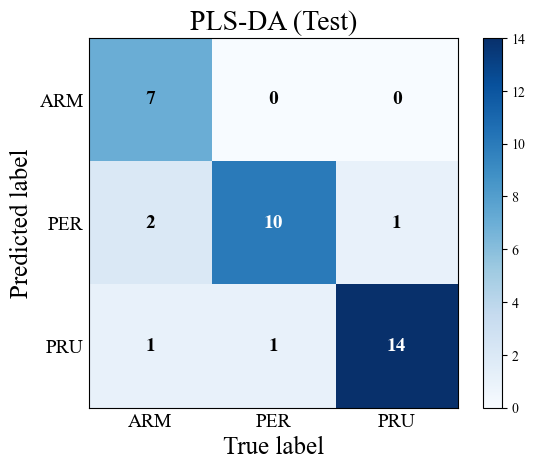

In [29]:
import scikitplot as skplt
mapping = { 0: 'ARM',   1: 'PER',2: 'PRU'} 

y_test_map= [mapping[i] if i in mapping else i for i in y_test] 
y_pred_test_map = [mapping[i] if i in mapping else i for i in np.array(y_pred_test)] 
plot = skplt.metrics.plot_confusion_matrix(y_test_map, y_pred_test_map)

plt.tick_params(axis='both', which='both', length=0)  
plt.title('PLS-DA (Test)', fontsize=20)
# 设置标题和轴标签，并修改字体大小
plt.xlabel("True label", fontsize=18)  # X轴标签字体大小
plt.ylabel("Predicted label", fontsize=18)  # Y轴标签字体大小
# 调整刻度标签的字体大小
plt.xticks(fontsize=14)  # X轴刻度标签字体大小
plt.yticks(fontsize=14)  # Y轴刻度标签字体大小
# 调整单元格内数字的字体大小
for text in plot.texts:
    text.set_fontsize(14)  
    text.set_fontweight("bold")  # 如果要加粗
plt.savefig('PLS-DA_TRAIN.png', dpi=800,bbox_inches='tight') 
plt.show()

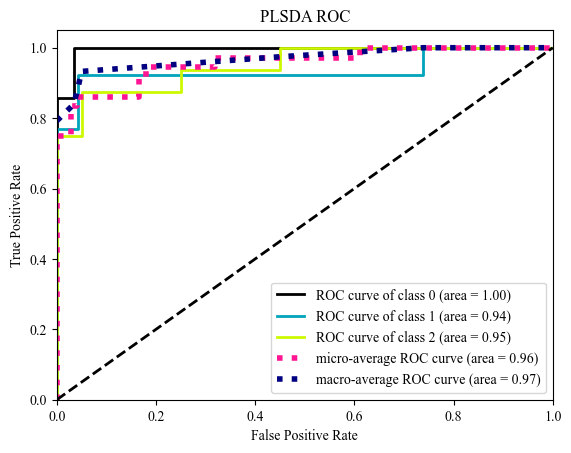

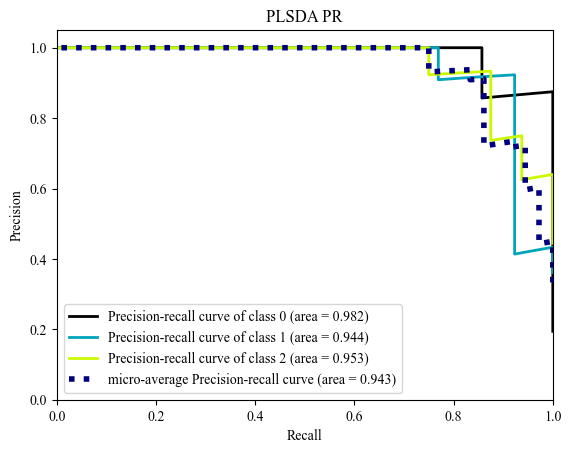

Classes: [0, 1, 2]


In [ ]:
# =========================
# file: notebooks/PLSDA_add_roc_pr.py (as a cell in your ipynb)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import scikitplot as skplt

def _softmax_rows(a: np.ndarray) -> np.ndarray:
    """行级 softmax；保证数值稳定。"""
    if a.ndim != 2:
        raise ValueError("Expected 2D array for scores.")
    a_max = np.max(a, axis=1, keepdims=True)
    exp_a = np.exp(a - a_max)
    sum_exp = np.sum(exp_a, axis=1, keepdims=True)
    # 避免除 0
    sum_exp[sum_exp == 0.0] = 1.0
    return exp_a / sum_exp

def _encode_with_labels(y, class_labels):
    """按给定 class_labels 顺序，将原始 y 映射为 [0..K-1]。"""
    idx_map = {lbl: i for i, lbl in enumerate(class_labels)}
    try:
        return np.array([idx_map[v] for v in y])
    except KeyError as e:
        raise ValueError(f"y 中包含未在 class_labels 中的标签: {e}. 请检查标签或显式传入 class_labels。")

def plsda_proba_and_plots(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    n_components: int,
    class_labels: list[str] | None = None,
    prefix: str = "PLSDA",
    cmap: str = "CMRmap",
    dpi: int = 800
):
    """
    重新训练与 PLS_DA 一致的 PLSRegression，输出多分类 ROC/PR 曲线并保存。
    备注：PLSRegression 没有 predict_proba，这里用连续输出经 softmax 近似概率。
    """
    # 1) 拟合与 one-hot
    model = PLSRegression(n_components=n_components)
    y_train_1h = pd.get_dummies(y_train)

    # 若未显式传 class_labels，则使用 one-hot 列顺序
    if class_labels is None:
        class_labels = list(y_train_1h.columns)

    # 重要：one-hot 列需要与 class_labels 对齐（以保证列顺序一致）
    missing = [c for c in class_labels if c not in y_train_1h.columns]
    if missing:
        raise ValueError(f"训练集中缺少以下类别（无法 one-hot 对齐）：{missing}")
    y_train_1h = y_train_1h.reindex(columns=class_labels, fill_value=0)

    model.fit(X_train, y_train_1h.values)

    # 2) 连续得分 -> softmax 概率
    def _scores_to_proba(scores: np.ndarray) -> np.ndarray:
        # 有些情况下得分幅度大/有负值，softmax 可统一映射到 (0,1)
        return _softmax_rows(scores)

    scores_train = model.predict(X_train)
    scores_val   = model.predict(X_val)
    scores_test  = model.predict(X_test)

    y_proba_train = _scores_to_proba(scores_train)
    y_proba_val   = _scores_to_proba(scores_val)
    y_proba_test  = _scores_to_proba(scores_test)

    # 3) y 真值按 class_labels 编码为整数
    y_train_enc = _encode_with_labels(np.asarray(y_train), class_labels)
    y_val_enc   = _encode_with_labels(np.asarray(y_val),   class_labels)
    y_test_enc  = _encode_with_labels(np.asarray(y_test),  class_labels)

    # 4) 画 ROC
    try:
        ax = skplt.metrics.plot_roc(y_test_enc, y_proba_test)  # scikit-plot 常用 API
    except AttributeError:
        ax = skplt.metrics.plot_roc_curve(y_test_enc, y_proba_test)  # 兼容你原有写法
    plt.title(f"{prefix} ROC")
    plt.savefig(f"{prefix} roc.png", dpi=dpi, bbox_inches="tight")
    plt.show()

    # 5) 画 PR
    ax = skplt.metrics.plot_precision_recall(y_test_enc, y_proba_test)
    plt.title(f"{prefix} PR")
    plt.savefig(f"{prefix} pr.png", dpi=dpi, bbox_inches="tight")
    plt.show()

    # 返回便于后续分析/复用
    return {
        "class_labels": class_labels,
        "y_proba": {"train": y_proba_train, "val": y_proba_val, "test": y_proba_test},
        "y_true_encoded": {"train": y_train_enc, "val": y_val_enc, "test": y_test_enc},
        "model": model,
    }

# ---------------- 使用示例（与你笔记本变量名严格一致） ----------------
# 若你想自定义类别顺序（例如固定为论文中的标签顺序），取消注释：
# custom_labels = ["ARM", "PER", "PRU"]    # 或使用你的真实顺序
# out = plsda_proba_and_plots(X_train, X_val, X_test, y_train, y_val, y_test,
#                             n_components=7, class_labels=custom_labels, prefix="PLSDA", cmap="CMRmap")

# 默认用训练集出现的类别顺序：
out = plsda_proba_and_plots(X_train, X_val, X_test, y_train, y_val, y_test,
                            n_components=7, class_labels=None, prefix="PLSDA", cmap="CMRmap")
print("Classes:", out["class_labels"])
